# Aufgabe 2: Visual Words

In Aufgabe 1 haben Sie einen lokalen Bilddeskriptor kennengelernt und selbständig implementiert. Dieser soll nun die Grundlage für das sogenannte Bag-of-Features Modell bilden. Der allgemeine Ansatz lässt sich wie folgt zusammenfassen:
1. Berechnen von Bilddeskriptoren anhand eines regulären Gitters (Alle Bilder im Datensatz)
2. Bestimmen "typischer" Deskriptoren (visuelle Wörter) durch Clusteranalyse
3. Quantisieren der vorkommenenden Deskriptoren auf visuelle Wörter
4. Repräsentation der Bilder durch Histogramme über die visuellen Wörter

In dieser Aufgabe sollen Sie sich näher mit dem Konzept der visuellen Wörter auseinandersetzen. Als Beispieldatensatz nutzen wir den [STL10](https://pytorch.org/vision/stable/generated/torchvision.datasets.STL10.html), welcher Bilder von zehn verschiedenen Klassen enthält. Zunächst berechnen Sie mit Hilfe der zuvor implementierten Funktionen für jedes Bild entsprechende lokale Deskriptoren. Diese sollen anschließend mit dem Loyd Algorithmus zu Clustern zusammengefasst werden. Diese Cluster werden abschließend visualisiert. Dies ermöglicht eine gewisse Interpretation der "gelernten" visuellen Wörter und zeigt, weshalb diese gut als Grundlage zur Klassifikation geeignet sind.

In [1]:
%load_ext autoreload
%autoreload 2

# Verwednung von matplotlib inline oder widget
%matplotlib inline

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


#import our dataset from pytorch library 

path = '/data/torchvision'

train_ds = datasets.STL10(root=path,
                          split='train',
                          transform=transforms.ToTensor())

test_ds = datasets.STL10(root=path,
                         split='test',
                         transform=transforms.ToTensor())

#labels represent an orray wich conatains 5000 point 
#each point is classifed to a class 
#the label gives us the points wich have the same class 


labels = train_ds.labels # Liste mit Labels (KlassenIDs) des Trainingsdatensatzes
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # Klassen des STL10
class_id_dict = dict(zip(classes, range(10))) # Dictionary um Klassenlabel (string) auf ID abzubilden

Visualisieren Sie zunächst die ersten 100 Beispiele der Klasse `bird`.

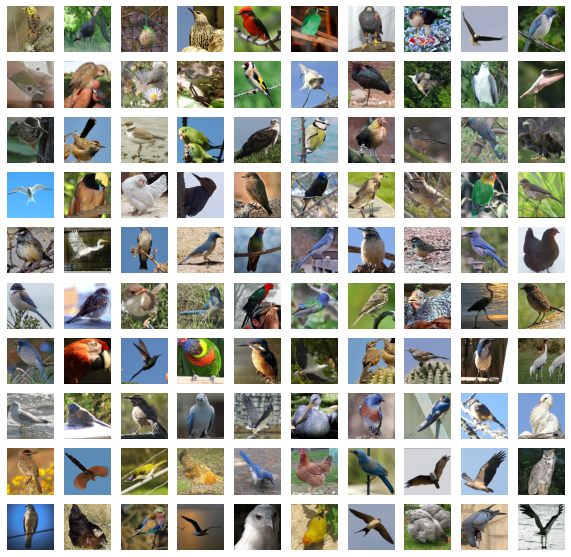

In [2]:
examples = np.where(labels==1)[0][:100] # Liste mit Indizes der darzustellenden Bilder
#raise NotImplementedError()

plt.figure(figsize=(10, 10))
for i , index in enumerate(examples):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    #img = np.zeros((96, 96))
    img,label=train_ds[index]
    img=np.array(img).transpose((1,2,0))
    #raise NotImplementedError()
    plt.imshow(img)

# Visuelle Wörter

Im Folgenden sollen nun für zehn examplarische Bilder der Klasse `bird` visuelle Wörter berechnet werden. Vervollständingen Sie zunächst die Visualisierung. Die erste Reihe zeigt die Beispielbilder, welche zunächst auf Graustufenbilder (Reihe zwei) abgebildet werden. Reihe drei soll analog zu Aufgabe eins die Darstellung der Bildgradienten enthalten. Nutzen Sie wieder den HSV Farbraum, um quantisierte Orientierung und Magnituden darzustellen. Darüber hinaus ist die folgende Unterteilung in lokale Bildbereiche angedeutet, welche anschließend auf Deskriptoren abbgebildet werden.

Berechnen Sie für jeden Bildbereich (Patch von 32x32 Pixeln) einen lokalen Bildeskriptor mit Hilfe der von Ihnen implementierten Funktion `compute_descriptor` mit 4 Zellen. Die Liste `desc_list` enthält alle Deskriptoren, wobei diese über ein Tupel repräsentiert werden, das wie folgt aufgebaut ist `(Index, Koordinate der oberen linken Ecke, Deskriptor)`. Fassen Sie alle Deskriptoren (nicht die Tupel!) der Beispielbilder in der Matrix `desc_mat` zusammen. Welche Dimension hat diese Matrix für eine Deskriptorgröße von 32 Pixeln, wenn sich die berechneten Deskriptoren in einem Bild nicht überlappen?

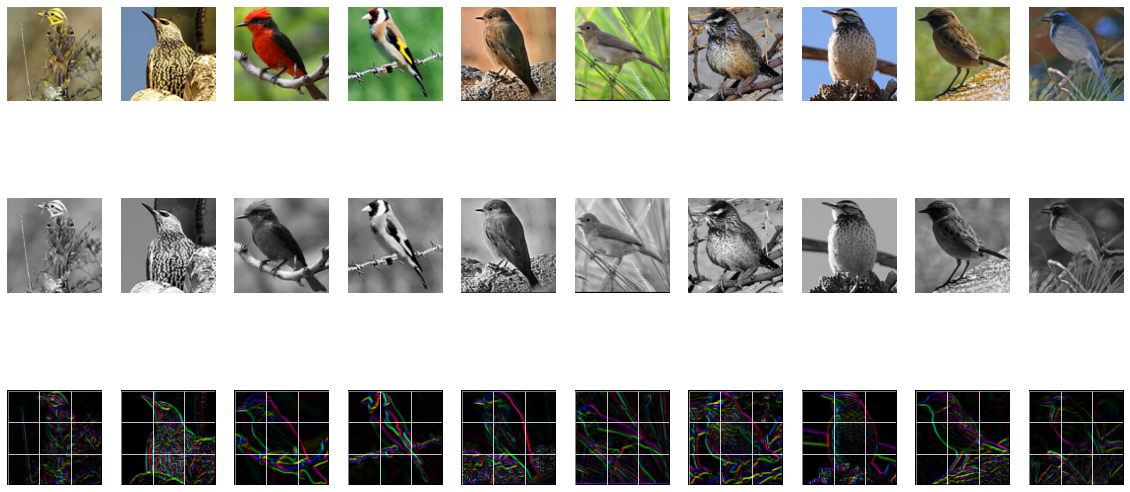

In [3]:
import cv2
import matplotlib
from matplotlib.patches import Rectangle

from common.descriptor import compute_image_gradient
from common.descriptor import compute_descriptor

desc_size = 32

examples = [0, 21, 24, 114, 321, 373, 380, 457, 555, 557]
desc_list = []
labels_list = []

plt.figure(figsize=(20,10))
for i, index in enumerate(examples):
    plt.subplot(3,10,i+1)
    plt.axis('off')
    img = np.zeros((96,96,3))
    img = train_ds[index][0].permute((1,2,0))
    labels_list.append(i)
    plt.imshow(img)

    plt.subplot(3,10, i+11)
    plt.axis('off')
    gray_img = np.zeros((96,96,1))
    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    gray_img = 0.2989 * R + 0.587 * G + 0.114 * B
    plt.imshow(gray_img, cmap='gray')

    magnitudes, orientations, quantized_orientations = compute_image_gradient(gray_img.numpy())
    gradient_img_rgb = np.zeros((96,96,3))
    
    gradient_directions_shape = list(orientations.shape)
    gradient_directions_shape.append(3)
    gradient_directions_hsv = np.ones(tuple(gradient_directions_shape))
    gradient_directions_hsv[:,:,0] = orientations

    gradient_directions_magnitudes_hsv = np.ones(tuple(gradient_directions_shape))
    gradient_directions_magnitudes_hsv[:,:,0] = orientations
    gradient_directions_magnitudes_hsv[:,:,2] = magnitudes

    gradient_directions_rgb = matplotlib.colors.hsv_to_rgb(gradient_directions_hsv)
    gradient_img_rgb = matplotlib.colors.hsv_to_rgb(gradient_directions_magnitudes_hsv)

    ax = plt.subplot(3,10, i+21)
    plt.axis('off')

    plt.imshow(gradient_img_rgb)
    
    for x in range(gradient_img_rgb.shape[1] // desc_size):
        for y in range(gradient_img_rgb.shape[0] // desc_size):
            ul = (x*desc_size, y*desc_size)
            
            patch_orientations = quantized_orientations[ul[1]:ul[1]+desc_size,ul[0]:ul[0]+desc_size]
            patch_magnitudes = magnitudes[ul[1]:ul[1]+desc_size,ul[0]:ul[0]+desc_size]
            
            rect = Rectangle(ul, desc_size, desc_size, alpha=.5, lw=1, fill=None, color='w')
            ax.add_patch(rect)

            desc = np.zeros(128)
            desc = compute_descriptor(patch_orientations, patch_magnitudes)

            desc_list.append((index, ul, desc))

desc_mat = np.zeros((90,11))


descs = list()

for i,j,k in desc_list:
    descs.append(k)

desc_mat = np.vstack(descs)


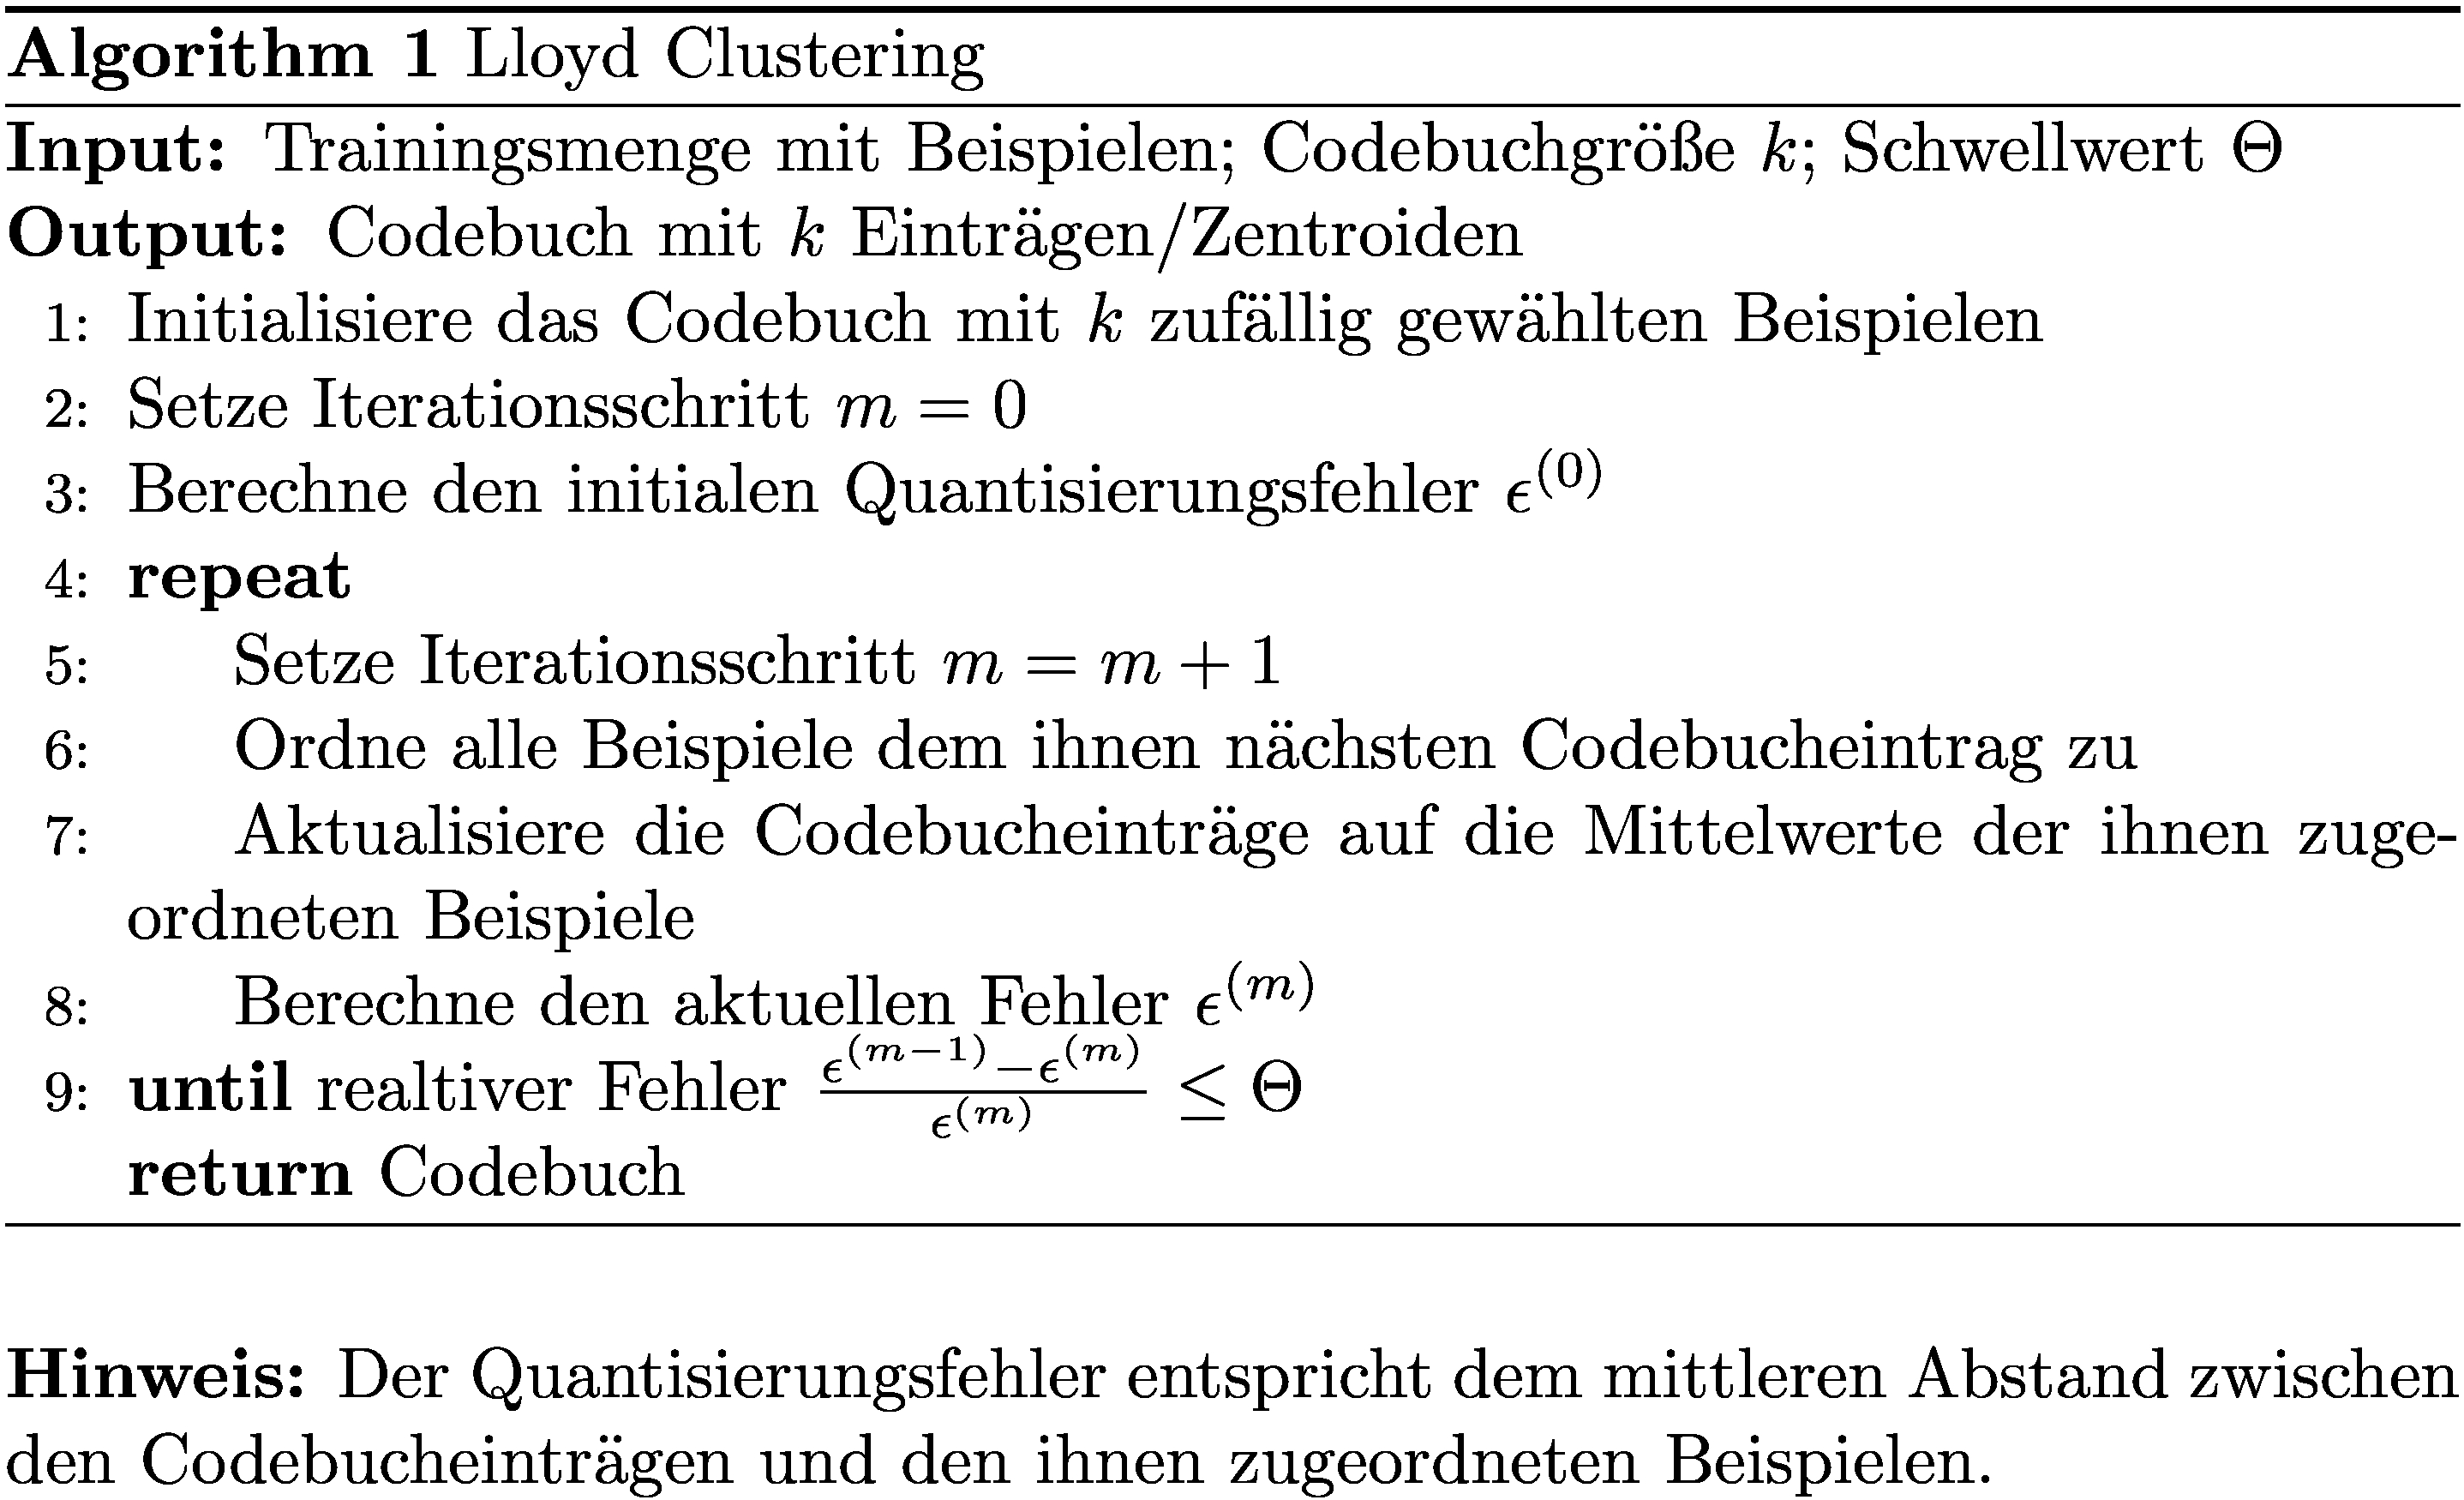# Lloyd Clustering

Ordnen Sie nun die in der Variablen `desc_mat` enthaltenden Deskriptoren einer festen Anzahl (`n_vw`) von Clusterzentren zu. Daraus resultiert ein sogenanntes Codebuch, welches typische Featureausprägungen enthält, welche über ihren Zentroiden repräsentiert werden können. Dies lässt sich über ein Array der Dimension `Anzahl der Visual Words` x `Größe der Deskriptoren` darstellen. Jeder Deskriptor wird im Folgenden einem visuellen Wort (label) zugeordnet, welches nur über eine ID (Integer) abgebildet werden kann. Implementieren Sie dafür nun den Lloyd Algorythmus.

**Hinweis:** Die Funktion `cdist` berechnet die Distanzen zwischen Matrizen. Somit können die Distanzen zwischen allen Zentroiden und allen Samples in einem Aufruf ausgerechnet werden. Für eine eimalige Zuordnung von Samples zu Zentroiden ist daher keine Schleife erforderlich!

![Lloyds Algorithmus](./images/lloyd_algo.jpg)


In [8]:
'''
step 1  : calculate the matrix distance using the cdist funvtion 
step2 :   inittial calculate the quntitzed error 
step 3 :  create the labels wich is created according to the min distance between each centroide and each point
step4  : assign each discriptor wich have the same label to the codebook 
step5 :calculate the meanm
discrniptor shaoe ( 90 , 128  ) 
the codebook shape  (10 ,128) 

'''

from scipy.spatial.distance import cdist

n_vw = 10 # Groesse des Codebuchs

n_samples = desc_mat.shape[0] # Groesse der Traningsmenge

labels = np.zeros(n_samples)
# Array zum speichern der Zuordnung der Traningsbeispiele zu den Codebucheintraegen
# Codebuch mit n_vw zufaellig gewaehlten Traningsbeispielen initialisieren

codebook_init_index = np.random.permutation(n_samples)[:n_vw]

codebook = np.array(desc_mat[codebook_init_index,:])
# for each simpmle calculate the distance to each other discirptor  
#assign that discriptor to the according to the distance  


distances  = cdist(desc_mat , codebook  ) 
print ( distances.astype(int)) 

# Initialien Quantisierungsfehler bestimmen

distances  = cdist(desc_mat , codebook  ) 

quant_err =  np.mean( np.max(distances)) 

labels = np.argmin(distances ,axis = 1 )

print('Initialer Quantisierungsfehler: %.2f' % quant_err)
relativer_fehler = 1 
quant_err_thresh = 0.0001
while relativer_fehler > quant_err_thresh : 
    old_quant_err = quant_err
    clusters = []
    for  i  in range  (n_vw )   :
        clusters.append(desc_mat[labels==i  ,  : ])# each descriptoer will be assigned to a cluster according to the lables id
        
    for item  in clusters : 
        np.mean(item) 
    result = np.vstack(clusters)
    codebook=result # reassign the codebook  according to the new clusters 
    new_distances =cdist(desc_mat ,codebook)
    labels= np.argmin(distances ,axis = 1 )
    new_quant_err = np.mean( np.max(new_distances)) 
    relativer_fehler = (old_quant_err/new_quant_err)-1
    quant_err = new_quant_err



[[19 16 16 15 23 23 16 10 31  5]
 [19 17 17 16 23 24 16 11 31  8]
 [18 16 16 15 23 23 16 11 30  9]
 [21 24 24 26 25 25 24 24 31 25]
 [17 19 19 17 24 24 17 17 28 15]
 [19 21 21 21 26 24 21 21 28 20]
 [18 15 16 15 23 23 17 12 30  7]
 [15 18 19 18 23 21 17 16 28 15]
 [15 15 16 16 21 21 16 11 26 10]
 [21 19 15 15 25 25 20 13 32 12]
 [21 19 19 17 23 26 20 15 33 13]
 [24 24 20 25 30 30 24 21 32 21]
 [26 24 27 25 29 26 24 25 34 26]
 [25 30 30 28 30 28 28 30 33 30]
 [31 38 37 35 39 36 34 37 37 38]
 [18 16 16 16 22 23 16 11 31  9]
 [25 23 28 27 30 26 24 26 31 27]
 [18 21 24 22 26 24 20 18 25 22]
 [22 24 25 24 29 29 25 23 29 20]
 [23 23 22 21 25 27 21 21 33 21]
 [20 23 21 19 26 26 22 17 32 16]
 [19 18 18 21 26 21 19 18 31 16]
 [21 20 19  0 25 24 19 14 29 15]
 [24 27 30 31 32 30 30 28 33 28]
 [18 17 17 15 23 23 17 11 30  0]
 [22 18 22 20 27 28 23 18 31 18]
 [26 32 32 32 31 31 29 30 36 30]
 [24 26 26 24 31 28 25 23 31 22]
 [19 17 13 15 23 23 17 10 30  9]
 [17 22 20 21 24 25 21 16 30 17]
 [26 24 25

# TSNE

Für ein besseres Verständnis der visuellen Wörter und ihrer Clusterzugehörigkeiten, werden diese im Folgenden in einen zweidimensionalen Raum eingebettet. Hierzu wird zunächst die TSNE Methodik verwendet, um für jeden Bilddeskriptor eine x,y Koordinate zu berechnen. Die Distanz zwischen den Deskriptoren im neuen Unterraum korrespondiert zur Vektordistanz zwischen den hochdimensionalen Repräsentationen. Im Folgenden soll diese Einbettung visualisiert werden. Plotten Sie dazu für jeden Bilddeskriptor den zugehörigen Bildausschnitt an die aus dem TSNE resultierende Koordinate. Nutzen Sie die Funktion `Rectangle`, um einen Rahmen um jeden Patch zu erzeugen. Die Farbe der Umrandung wird entsprechend der Clusterzugehörigkeit gewählt.

Zunächst werden die TSNE Embeddings so normalisiert, dass sie relative (x,y) Koordinaten enthalten, wobei der Wertebereich jeder Raumrichtung auf $[0,1]$ beschränkt ist. Die `tsne_map` stellt das Ausgabebild dar, in welchen die Bildausschnitte der visuellen Wörter eingezeichnet werden sollen. Durch die Multiplikation der relativen Koordinaten mit der `map_size` können sie die entsprechende Position berechnen


**Tipp:** Die Funktion `Rectangle((x,y),width, height, color, fill=None, lw=3)` gibt ein Rechteck zurück, welches mit Hilfe von `ax.add_patch(...)` in die Axis eingezeichnet werden kann. Nutzen Sie die gegebene colormap, um die Cluster IDs auf Farbwerte abzubilden.

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


NotImplementedError: 

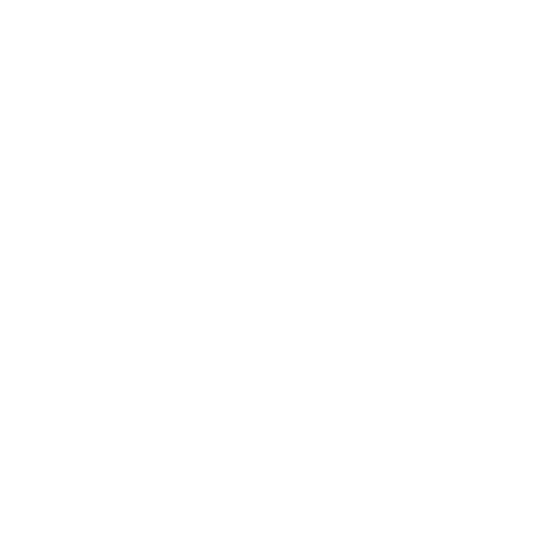

In [5]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

embedded = TSNE(n_components=2, init='random').fit_transform(desc_mat)
embedded = np.array(embedded)

# Normierung
embedded[:,0] = embedded[:,0] - np.min(embedded[:,0])
embedded[:,1] = embedded[:,1] - np.min(embedded[:,1])
embedded[:,0] = embedded[:,0] / np.max(embedded[:,0])
embedded[:,1] = embedded[:,1] / np.max(embedded[:,1])

map_size = 1000
tsne_map = np.ones((map_size, map_size, 3))


fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(tsne_map)
plt.axis('off')
colormap = cm.get_cmap('jet')

for i, ((index, ul, desc), xy) in enumerate(zip(desc_list, embedded)):
    raise NotImplementedError()

plt.imshow(tsne_map)